In [14]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torchsummary

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms.functional import resize, to_tensor, to_pil_image
from PIL import Image
from tqdm import tqdm


In [15]:

if torch.mps.is_available():
    device = torch.device('mps')
    dtype = torch.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(device)

mps


In [16]:
path = "images/birds.png"
im = Image.open(path).convert("RGB")
im_tensor_cpu = to_tensor(im).to(device="cpu")
im_tensor_mps =to_tensor(im).to(device="mps") 
print(f"inital tensor size : {im_tensor_cpu.shape}")


max_dim = 250
_, H, W = im_tensor_mps.shape
scale_factor = max_dim / max(H, W)

new_H = int(H * scale_factor)
new_W = int(W * scale_factor)
im_resized = resize(im_tensor_mps.unsqueeze(0), size=[new_H, new_W], antialias=True).squeeze(0) *2 -1

print(f"rescaled tensor size : {im_resized.shape}")

inital tensor size : torch.Size([3, 164, 244])
rescaled tensor size : torch.Size([3, 168, 249])


In [17]:
          # dimension mini au coarse scale
N = 1
current_H, current_W = new_H, new_W
r = 4 / 3               # scaling factor (environ 1.333)
min_dim = 25  
# Calculer N tel que le coarse scale soit >= min_dim
while current_H >= min_dim and current_W >= min_dim:
    N += 1
    current_H = int(current_H / r)
    current_W = int(current_W / r)
N

8

In [18]:
scales = [im_resized.unsqueeze(0)]    # niveau 0 = fine

for i in range(1, N):
    prev = scales[-1]
    _, _, h, w = prev.shape
    new_h = max(int(h / r), 1)
    new_w = max(int(w / r), 1)
    down = resize(prev, size=[new_h, new_w], antialias=True)
    scales.append(down)


Number of scales N = 8
Scaling factor r = 1.333
Scale 0 : torch.Size([1, 3, 168, 249])


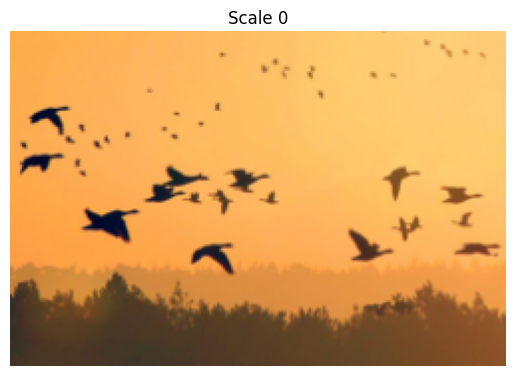

Scale 1 : torch.Size([1, 3, 126, 186])


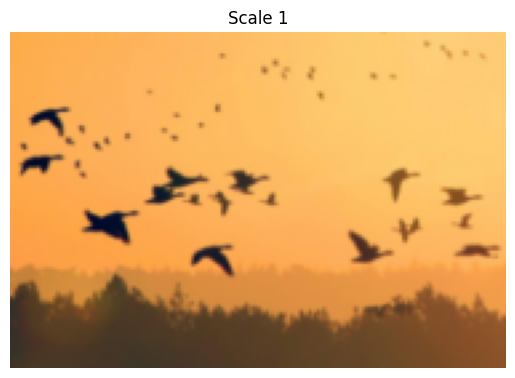

Scale 2 : torch.Size([1, 3, 94, 139])


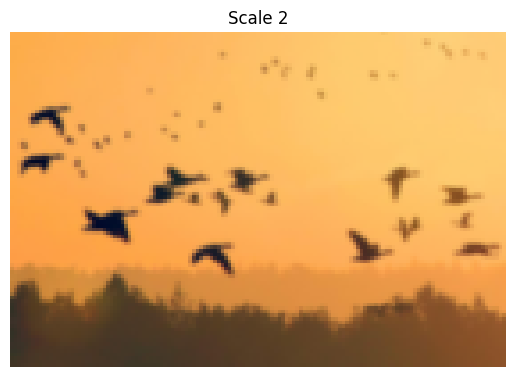

Scale 3 : torch.Size([1, 3, 70, 104])


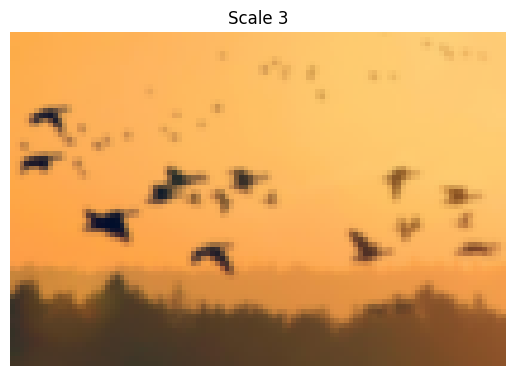

Scale 4 : torch.Size([1, 3, 52, 78])


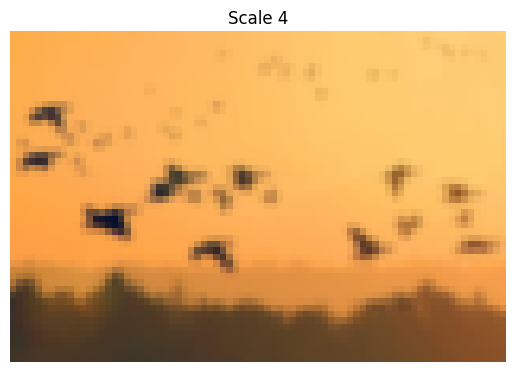

Scale 5 : torch.Size([1, 3, 39, 58])


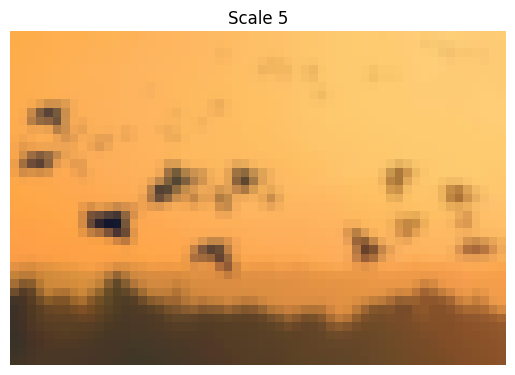

Scale 6 : torch.Size([1, 3, 29, 43])


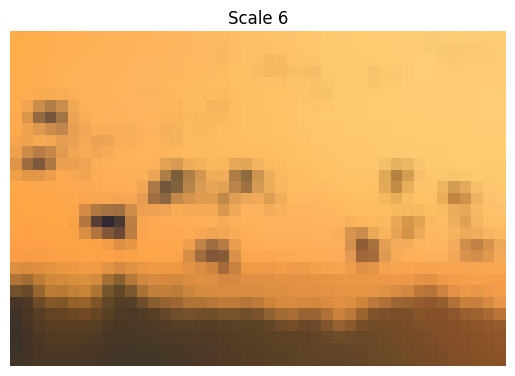

Scale 7 : torch.Size([1, 3, 21, 32])


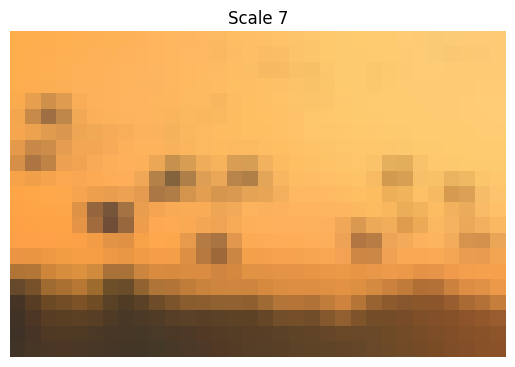

In [19]:
def pil_from_minus1to1(t):
    """
    Convertit un tenseur [-1,1] (CHW ou 1,C,H,W) en PIL Image.
    """
    t = t.squeeze(0) if t.dim() == 4 else t          # B×C×H×W → C×H×W
    t = ((t.clamp(-1, 1) + 1) / 2)                   # [-1,1] → [0,1]
    return to_pil_image(t.cpu())



print(f"Number of scales N = {N}")
print(f"Scaling factor r = {r:.3f}")
for i, im_scale in enumerate(scales):
    print(f"Scale {i} : {im_scale.shape}")
    plt.imshow(pil_from_minus1to1(im_scale.squeeze().cpu()))
    plt.axis('off')
    plt.title(f"Scale {i}")
    plt.show()


In [20]:
class Generator(nn.Module):
    
    def __init__(self,n_hidden):
        super().__init__()
        self.n_hidden = n_hidden
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=self.n_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            # Last conv layer outputs 3 channels (RGB), no batchnorm or activation
            nn.Conv2d(self.n_hidden, 3, 3, padding=1),
            nn.Tanh()
        )
        
    def forward(self,input):
        return self.main(input)

In [21]:
class Discriminator(nn.Module):
    def __init__(self,n_hidden):
        
        super().__init__()
        self.n_hidden = n_hidden
        self.main = nn.Sequential(
            nn.Conv2d(3, self.n_hidden, kernel_size=3, padding=1),  
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, 1, 3, padding=1)  
        )
    
    def forward(self,input):
        return self.main(input)

In [22]:
input_size_visu = (3, 1024, 1024)
netG_visu = Generator(n_hidden=32).to("cpu")
torchsummary.summary(netG_visu, input_size=input_size_visu,device="cpu")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 32, 1024, 1024]             896
       BatchNorm2d-2       [-1, 32, 1024, 1024]              64
         LeakyReLU-3       [-1, 32, 1024, 1024]               0
            Conv2d-4       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-5       [-1, 32, 1024, 1024]              64
         LeakyReLU-6       [-1, 32, 1024, 1024]               0
            Conv2d-7       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-8       [-1, 32, 1024, 1024]              64
         LeakyReLU-9       [-1, 32, 1024, 1024]               0
           Conv2d-10       [-1, 32, 1024, 1024]           9,248
      BatchNorm2d-11       [-1, 32, 1024, 1024]              64
        LeakyReLU-12       [-1, 32, 1024, 1024]               0
           Conv2d-13        [-1, 3, 1024, 1024]             867
             Tanh-14        [-1, 3, 102

In [23]:
netD_visu = Discriminator(n_hidden=32).to("cpu")
torchsummary.summary(netD_visu, input_size=input_size_visu,device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 32, 1024, 1024]             896
       BatchNorm2d-2       [-1, 32, 1024, 1024]              64
         LeakyReLU-3       [-1, 32, 1024, 1024]               0
            Conv2d-4       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-5       [-1, 32, 1024, 1024]              64
         LeakyReLU-6       [-1, 32, 1024, 1024]               0
            Conv2d-7       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-8       [-1, 32, 1024, 1024]              64
         LeakyReLU-9       [-1, 32, 1024, 1024]               0
           Conv2d-10       [-1, 32, 1024, 1024]           9,248
      BatchNorm2d-11       [-1, 32, 1024, 1024]              64
        LeakyReLU-12       [-1, 32, 1024, 1024]               0
           Conv2d-13        [-1, 1, 1024, 1024]             289
Total params: 29,185
Trainable params: 

+ Générations des generateurs/discriminateurs

In [24]:
hidden_lowest_dim = 32
Genarators = []
Discriminators = []

for i in range(len(scales)):
    r = N-i
    Genarators.append(Generator( hidden_lowest_dim *  2**(r//4)).to(device))
    Discriminators.append(Discriminator(hidden_lowest_dim * 2**(r//4)).to(device))
    
Genarators.reverse()
Discriminators.reverse()

for gen in Genarators : 
     print(gen.n_hidden)
for dis in Discriminators:
     print(dis.n_hidden)


32
32
32
64
64
64
64
128
32
32
32
64
64
64
64
128


+ Boucle d'entrainement 

In [25]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1 or classname.find('InstanceNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


for G in Genarators:
    G.apply(weights_init)
for D in Discriminators:
    D.apply(weights_init)

In [26]:
import torch, torch.linalg as LA

def _cov(x, mean):
    x_centered = x - mean
    return x_centered.T @ x_centered / (x.shape[0] - 1)

def sqrtm(A, num_iter=10):
    # Newton–Schulz iteration: differentiable, no eigen-decompositions
    Y, Z = A / A.trace(), torch.eye(A.size(0), device=A.device)
    for _ in range(num_iter):
        T = 0.5*(3*torch.eye(A.size(0), device=A.device) - Z @ Y)
        Y, Z = Y @ T, T @ Z
    return Y * A.trace().sqrt()

def w2_gaussian_loss(f_real, f_fake, eps=1e-6):
    m_r, m_g = f_real.mean(0), f_fake.mean(0)
    C_r = _cov(f_real, m_r) + eps*torch.eye(f_real.size(1), device=f_real.device)
    C_g = _cov(f_fake, m_g) + eps*torch.eye(f_fake.size(1), device=f_fake.device)

    A = sqrtm(C_g @ C_r @ C_g)
    return (m_r - m_g).pow(2).sum() + (C_r + C_g - 2*A).trace()


it scale 7:   0%|          | 0/2000 [00:00<?, ?it/s]

[scale 7 | it 0]  Lips ≈ 0.19
[scale 7 | it 0]  LR = 5.00e-04


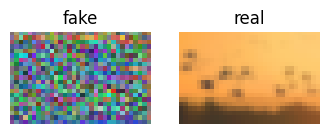

it scale 7:  10%|█         | 200/2000 [00:22<03:13,  9.33it/s]

[scale 7 | it 200]  Lips ≈ 1.11
[scale 7 | it 200]  LR = 5.00e-04


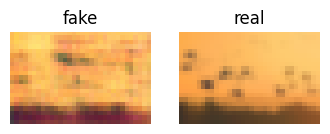

it scale 7:  20%|██        | 400/2000 [00:44<02:53,  9.22it/s]

[scale 7 | it 400]  Lips ≈ 1.26
[scale 7 | it 400]  LR = 5.00e-04


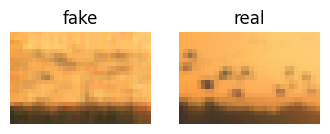

it scale 7:  30%|███       | 600/2000 [01:05<02:30,  9.31it/s]

[scale 7 | it 600]  Lips ≈ 1.44
[scale 7 | it 600]  LR = 5.00e-04


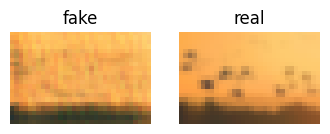

it scale 7:  40%|████      | 800/2000 [01:27<02:06,  9.45it/s]

[scale 7 | it 800]  Lips ≈ 1.32
[scale 7 | it 800]  LR = 5.00e-04


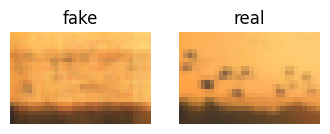

it scale 7:  50%|█████     | 1000/2000 [01:48<01:48,  9.21it/s]

[scale 7 | it 1000]  Lips ≈ 1.28
[scale 7 | it 1000]  LR = 5.00e-04


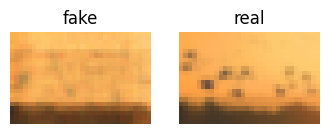

it scale 7:  60%|██████    | 1200/2000 [02:10<01:25,  9.40it/s]

[scale 7 | it 1200]  Lips ≈ 1.39
[scale 7 | it 1200]  LR = 5.00e-04


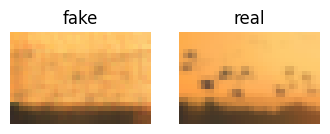

it scale 7:  70%|███████   | 1400/2000 [02:31<01:04,  9.35it/s]

[scale 7 | it 1400]  Lips ≈ 1.11
[scale 7 | it 1400]  LR = 5.00e-04


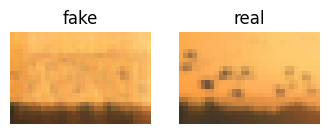

it scale 7:  80%|████████  | 1600/2000 [02:53<00:42,  9.35it/s]

[scale 7 | it 1600]  Lips ≈ 1.30
[scale 7 | it 1600]  LR = 5.00e-04


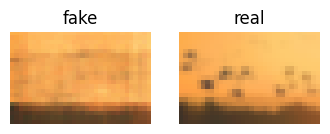

it scale 7:  90%|█████████ | 1800/2000 [03:15<00:21,  9.22it/s]

[scale 7 | it 1800]  Lips ≈ 1.42
[scale 7 | it 1800]  LR = 5.00e-04


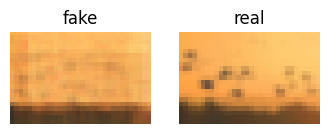

it scale 7: 100%|█████████▉| 1999/2000 [03:36<00:00,  9.48it/s]

[scale 7 | it 1999]  Lips ≈ 1.33
[scale 7 | it 1999]  LR = 5.00e-04


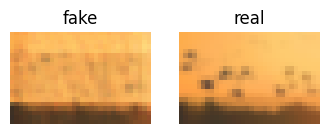

it scale 6:   0%|          | 0/2000 [00:00<?, ?it/s]           

[scale 6 | it 0]  Lips ≈ 0.03
[scale 6 | it 0]  LR = 5.00e-04


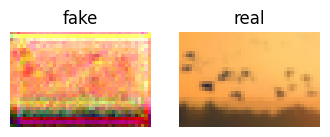

it scale 6:  10%|█         | 200/2000 [00:21<03:14,  9.26it/s]

[scale 6 | it 200]  Lips ≈ 0.75
[scale 6 | it 200]  LR = 5.00e-04


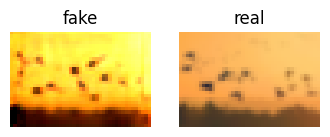

it scale 6:  20%|██        | 400/2000 [00:42<02:50,  9.40it/s]

[scale 6 | it 400]  Lips ≈ 0.94
[scale 6 | it 400]  LR = 5.00e-04


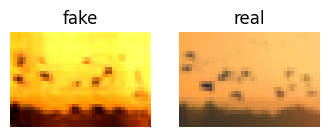

it scale 6:  30%|███       | 600/2000 [01:04<02:31,  9.25it/s]

[scale 6 | it 600]  Lips ≈ 0.88
[scale 6 | it 600]  LR = 5.00e-04


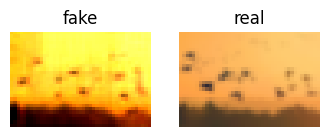

it scale 6:  40%|████      | 800/2000 [01:25<02:09,  9.29it/s]

[scale 6 | it 800]  Lips ≈ 1.36
[scale 6 | it 800]  LR = 5.00e-04


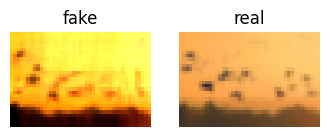

it scale 6:  50%|█████     | 1000/2000 [01:47<01:48,  9.19it/s]

[scale 6 | it 1000]  Lips ≈ 1.26
[scale 6 | it 1000]  LR = 5.00e-04


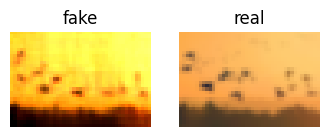

it scale 6:  60%|██████    | 1200/2000 [02:08<01:26,  9.29it/s]

[scale 6 | it 1200]  Lips ≈ 1.46
[scale 6 | it 1200]  LR = 5.00e-04


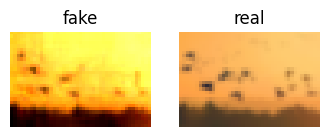

it scale 6:  70%|███████   | 1400/2000 [02:30<01:05,  9.22it/s]

[scale 6 | it 1400]  Lips ≈ 1.67
[scale 6 | it 1400]  LR = 5.00e-04


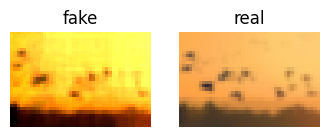

it scale 6:  80%|████████  | 1600/2000 [02:51<00:43,  9.25it/s]

[scale 6 | it 1600]  Lips ≈ 1.56
[scale 6 | it 1600]  LR = 5.00e-04


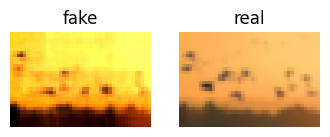

it scale 6:  90%|█████████ | 1800/2000 [03:13<00:21,  9.34it/s]

[scale 6 | it 1800]  Lips ≈ 0.94
[scale 6 | it 1800]  LR = 5.00e-04


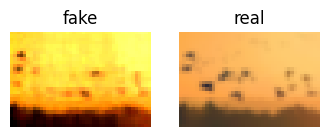

it scale 6: 100%|█████████▉| 1999/2000 [03:34<00:00,  9.47it/s]

[scale 6 | it 1999]  Lips ≈ 1.63
[scale 6 | it 1999]  LR = 5.00e-04


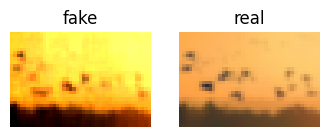

[init] copied weights from scale 6 → 5


it scale 5:   0%|          | 0/2000 [00:00<?, ?it/s]

[scale 5 | it 0]  Lips ≈ 0.73
[scale 5 | it 0]  LR = 5.00e-04


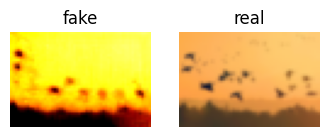

it scale 5:  10%|█         | 200/2000 [00:21<03:12,  9.34it/s]

[scale 5 | it 200]  Lips ≈ 0.92
[scale 5 | it 200]  LR = 5.00e-04


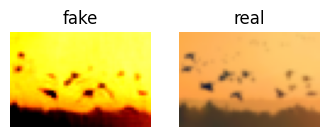

it scale 5:  20%|██        | 400/2000 [00:43<02:55,  9.14it/s]

[scale 5 | it 400]  Lips ≈ 1.06
[scale 5 | it 400]  LR = 5.00e-04


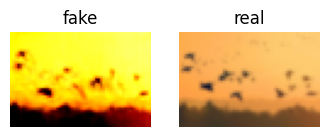

it scale 5:  30%|███       | 600/2000 [01:05<02:32,  9.21it/s]

[scale 5 | it 600]  Lips ≈ 1.07
[scale 5 | it 600]  LR = 5.00e-04


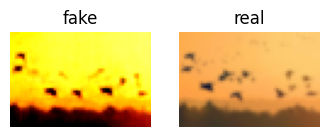

it scale 5:  40%|████      | 800/2000 [01:27<02:10,  9.22it/s]

[scale 5 | it 800]  Lips ≈ 2.28
[scale 5 | it 800]  LR = 5.00e-04


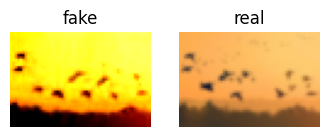

it scale 5:  50%|█████     | 1000/2000 [01:49<01:49,  9.16it/s]

[scale 5 | it 1000]  Lips ≈ 0.78
[scale 5 | it 1000]  LR = 5.00e-04


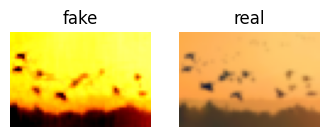

it scale 5:  60%|██████    | 1200/2000 [02:11<01:27,  9.16it/s]

[scale 5 | it 1200]  Lips ≈ 0.86
[scale 5 | it 1200]  LR = 5.00e-04


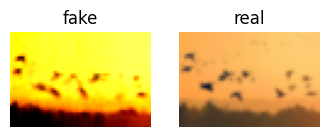

it scale 5:  70%|███████   | 1400/2000 [02:33<01:05,  9.15it/s]

[scale 5 | it 1400]  Lips ≈ 1.72
[scale 5 | it 1400]  LR = 5.00e-04


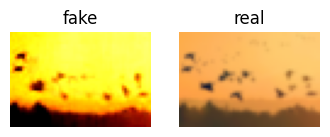

it scale 5:  80%|████████  | 1600/2000 [02:54<00:43,  9.12it/s]

[scale 5 | it 1600]  Lips ≈ 2.01
[scale 5 | it 1600]  LR = 5.00e-04


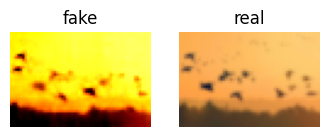

it scale 5:  90%|█████████ | 1800/2000 [03:16<00:21,  9.34it/s]

[scale 5 | it 1800]  Lips ≈ 1.01
[scale 5 | it 1800]  LR = 5.00e-04


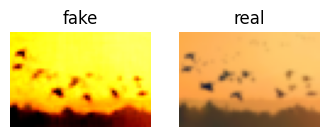

it scale 5: 100%|█████████▉| 1999/2000 [03:38<00:00,  9.21it/s]

[scale 5 | it 1999]  Lips ≈ 1.32
[scale 5 | it 1999]  LR = 5.00e-04


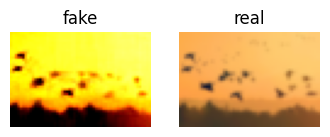

[init] copied weights from scale 5 → 4


it scale 4:   0%|          | 0/2000 [00:00<?, ?it/s]

[scale 4 | it 0]  Lips ≈ 1.24
[scale 4 | it 0]  LR = 5.00e-04


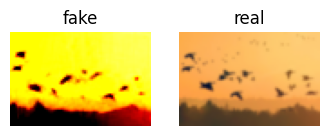

it scale 4:  10%|█         | 200/2000 [00:25<04:09,  7.21it/s]

[scale 4 | it 200]  Lips ≈ 1.05
[scale 4 | it 200]  LR = 5.00e-04


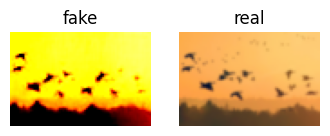

it scale 4:  20%|██        | 400/2000 [00:54<04:03,  6.58it/s]

[scale 4 | it 400]  Lips ≈ 2.29
[scale 4 | it 400]  LR = 5.00e-04


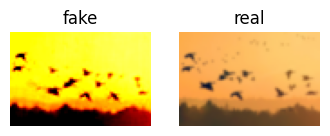

it scale 4:  30%|███       | 600/2000 [01:24<03:41,  6.31it/s]

[scale 4 | it 600]  Lips ≈ 1.06
[scale 4 | it 600]  LR = 5.00e-04


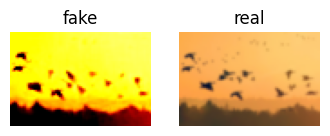

it scale 4:  40%|████      | 800/2000 [01:56<03:11,  6.27it/s]

[scale 4 | it 800]  Lips ≈ 0.83
[scale 4 | it 800]  LR = 5.00e-04


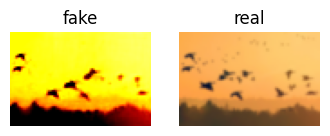

it scale 4:  50%|█████     | 1000/2000 [02:28<02:35,  6.42it/s]

[scale 4 | it 1000]  Lips ≈ 1.32
[scale 4 | it 1000]  LR = 5.00e-04


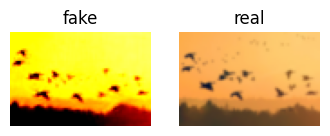

it scale 4:  60%|██████    | 1200/2000 [02:59<02:06,  6.35it/s]

[scale 4 | it 1200]  Lips ≈ 1.26
[scale 4 | it 1200]  LR = 5.00e-04


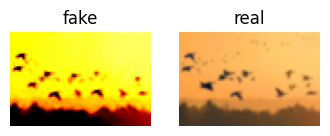

it scale 4:  70%|███████   | 1400/2000 [03:31<01:36,  6.22it/s]

[scale 4 | it 1400]  Lips ≈ 2.72
[scale 4 | it 1400]  LR = 5.00e-04


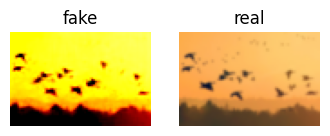

it scale 4:  80%|████████  | 1600/2000 [04:03<01:04,  6.19it/s]

[scale 4 | it 1600]  Lips ≈ 1.47
[scale 4 | it 1600]  LR = 5.00e-04


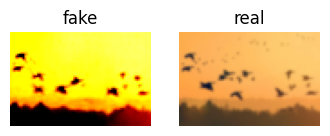

it scale 4:  90%|█████████ | 1800/2000 [04:35<00:32,  6.24it/s]

[scale 4 | it 1800]  Lips ≈ 0.94
[scale 4 | it 1800]  LR = 5.00e-04


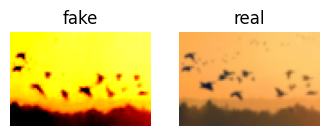

it scale 4: 100%|█████████▉| 1999/2000 [05:06<00:00,  6.29it/s]

[scale 4 | it 1999]  Lips ≈ 2.57
[scale 4 | it 1999]  LR = 5.00e-04


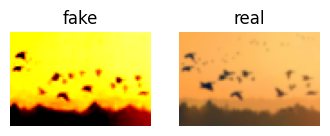

[init] copied weights from scale 4 → 3


it scale 3:   0%|          | 0/2000 [00:00<?, ?it/s]

[scale 3 | it 0]  Lips ≈ 0.99
[scale 3 | it 0]  LR = 5.00e-04


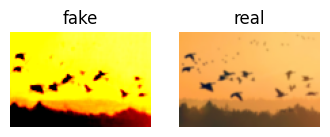

it scale 3:  10%|█         | 200/2000 [00:45<06:49,  4.40it/s]

[scale 3 | it 200]  Lips ≈ 1.97
[scale 3 | it 200]  LR = 5.00e-04


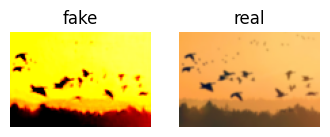

it scale 3:  20%|██        | 400/2000 [01:30<06:00,  4.43it/s]

[scale 3 | it 400]  Lips ≈ 1.05
[scale 3 | it 400]  LR = 5.00e-04


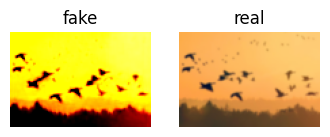

it scale 3:  30%|███       | 600/2000 [02:15<05:19,  4.38it/s]

[scale 3 | it 600]  Lips ≈ 1.50
[scale 3 | it 600]  LR = 5.00e-04


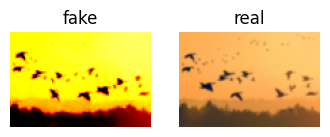

it scale 3:  40%|████      | 800/2000 [03:01<04:33,  4.39it/s]

[scale 3 | it 800]  Lips ≈ 1.50
[scale 3 | it 800]  LR = 5.00e-04


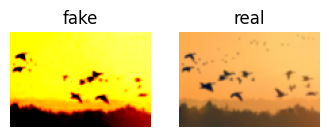

it scale 3:  50%|█████     | 1000/2000 [03:46<03:47,  4.39it/s]

[scale 3 | it 1000]  Lips ≈ 1.46
[scale 3 | it 1000]  LR = 5.00e-04


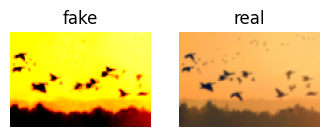

it scale 3:  60%|██████    | 1200/2000 [04:31<03:00,  4.44it/s]

[scale 3 | it 1200]  Lips ≈ 1.20
[scale 3 | it 1200]  LR = 5.00e-04


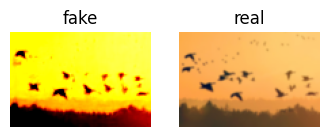

it scale 3:  70%|███████   | 1400/2000 [05:17<02:15,  4.42it/s]

[scale 3 | it 1400]  Lips ≈ 2.55
[scale 3 | it 1400]  LR = 5.00e-04


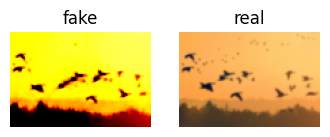

it scale 3:  80%|████████  | 1600/2000 [06:02<01:31,  4.37it/s]

[scale 3 | it 1600]  Lips ≈ 1.11
[scale 3 | it 1600]  LR = 5.00e-04


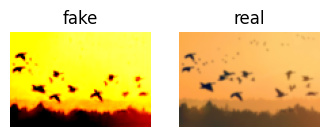

it scale 3:  90%|█████████ | 1800/2000 [06:48<00:45,  4.39it/s]

[scale 3 | it 1800]  Lips ≈ 1.85
[scale 3 | it 1800]  LR = 5.00e-04


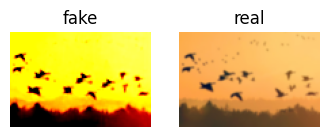

it scale 3: 100%|█████████▉| 1999/2000 [07:33<00:00,  4.41it/s]

[scale 3 | it 1999]  Lips ≈ 1.82
[scale 3 | it 1999]  LR = 5.00e-04


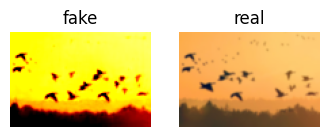

it scale 2:   0%|          | 0/2000 [00:00<?, ?it/s]           

[scale 2 | it 0]  Lips ≈ 0.03
[scale 2 | it 0]  LR = 5.00e-04


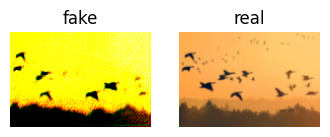

it scale 2:  10%|█         | 200/2000 [00:34<05:03,  5.92it/s]

[scale 2 | it 200]  Lips ≈ 0.43
[scale 2 | it 200]  LR = 5.00e-04


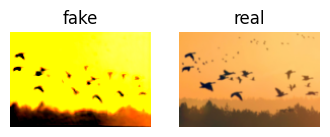

it scale 2:  20%|██        | 400/2000 [01:08<04:31,  5.89it/s]

[scale 2 | it 400]  Lips ≈ 0.65
[scale 2 | it 400]  LR = 5.00e-04


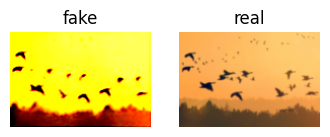

it scale 2:  30%|███       | 600/2000 [01:43<03:58,  5.86it/s]

[scale 2 | it 600]  Lips ≈ 0.80
[scale 2 | it 600]  LR = 5.00e-04


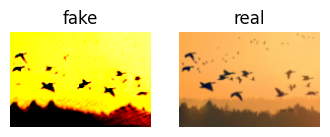

it scale 2:  40%|████      | 800/2000 [02:18<03:27,  5.78it/s]

[scale 2 | it 800]  Lips ≈ 0.79
[scale 2 | it 800]  LR = 5.00e-04


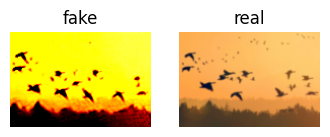

it scale 2:  50%|█████     | 1000/2000 [02:52<02:55,  5.71it/s]

[scale 2 | it 1000]  Lips ≈ 1.45
[scale 2 | it 1000]  LR = 5.00e-04


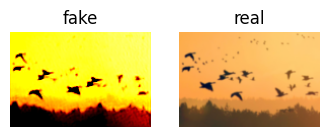

it scale 2:  60%|██████    | 1200/2000 [03:27<02:22,  5.61it/s]

[scale 2 | it 1200]  Lips ≈ 0.59
[scale 2 | it 1200]  LR = 5.00e-04


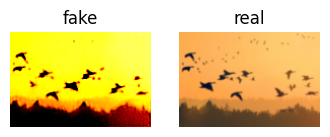

it scale 2:  70%|███████   | 1400/2000 [04:02<01:47,  5.56it/s]

[scale 2 | it 1400]  Lips ≈ 1.04
[scale 2 | it 1400]  LR = 5.00e-04


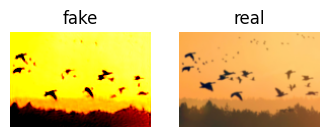

it scale 2:  80%|████████  | 1600/2000 [04:38<01:12,  5.54it/s]

[scale 2 | it 1600]  Lips ≈ 1.09
[scale 2 | it 1600]  LR = 5.00e-04


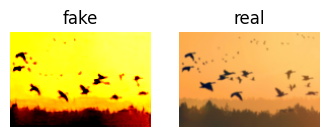

it scale 2:  90%|█████████ | 1800/2000 [05:14<00:36,  5.55it/s]

[scale 2 | it 1800]  Lips ≈ 0.95
[scale 2 | it 1800]  LR = 5.00e-04


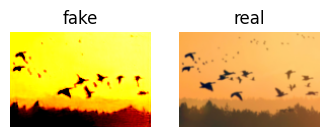

it scale 2: 100%|█████████▉| 1999/2000 [05:50<00:00,  5.54it/s]

[scale 2 | it 1999]  Lips ≈ 0.74
[scale 2 | it 1999]  LR = 5.00e-04


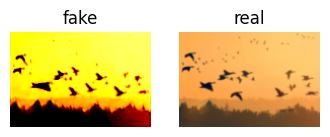

[init] copied weights from scale 2 → 1


it scale 1:   0%|          | 0/2000 [00:00<?, ?it/s]

[scale 1 | it 0]  Lips ≈ 1.02
[scale 1 | it 0]  LR = 5.00e-04


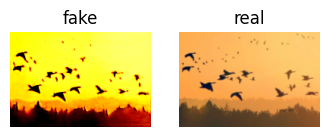

it scale 1:  10%|█         | 200/2000 [01:03<09:38,  3.11it/s]

[scale 1 | it 200]  Lips ≈ 1.11
[scale 1 | it 200]  LR = 5.00e-04


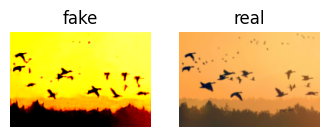

it scale 1:  20%|██        | 400/2000 [02:07<08:27,  3.15it/s]

[scale 1 | it 400]  Lips ≈ 1.26
[scale 1 | it 400]  LR = 5.00e-04


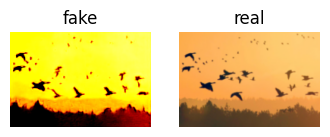

it scale 1:  30%|███       | 600/2000 [03:11<07:24,  3.15it/s]

[scale 1 | it 600]  Lips ≈ 1.86
[scale 1 | it 600]  LR = 5.00e-04


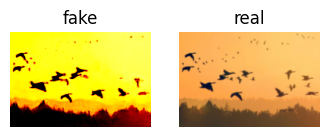

it scale 1:  40%|████      | 800/2000 [04:15<06:22,  3.13it/s]

[scale 1 | it 800]  Lips ≈ 1.15
[scale 1 | it 800]  LR = 5.00e-04


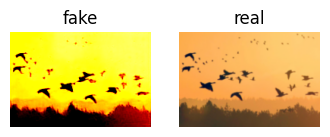

it scale 1:  50%|█████     | 1000/2000 [05:19<05:19,  3.13it/s]

[scale 1 | it 1000]  Lips ≈ 1.53
[scale 1 | it 1000]  LR = 5.00e-04


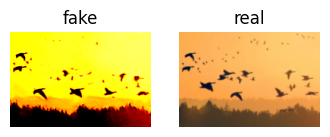

it scale 1:  60%|██████    | 1200/2000 [06:23<04:15,  3.14it/s]

[scale 1 | it 1200]  Lips ≈ 1.04
[scale 1 | it 1200]  LR = 5.00e-04


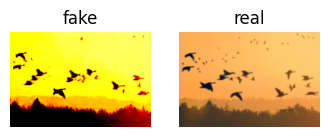

it scale 1:  70%|███████   | 1400/2000 [07:27<03:12,  3.11it/s]

[scale 1 | it 1400]  Lips ≈ 1.26
[scale 1 | it 1400]  LR = 5.00e-04


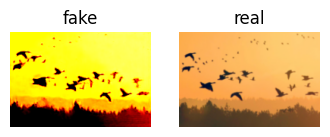

it scale 1:  80%|████████  | 1600/2000 [08:31<02:07,  3.13it/s]

[scale 1 | it 1600]  Lips ≈ 1.20
[scale 1 | it 1600]  LR = 5.00e-04


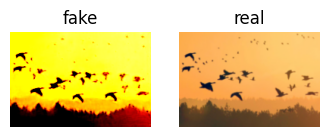

it scale 1:  90%|█████████ | 1800/2000 [09:35<01:03,  3.14it/s]

[scale 1 | it 1800]  Lips ≈ 1.03
[scale 1 | it 1800]  LR = 5.00e-04


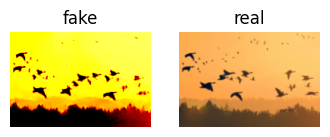

it scale 1: 100%|█████████▉| 1999/2000 [10:39<00:00,  3.12it/s]

[scale 1 | it 1999]  Lips ≈ 0.86
[scale 1 | it 1999]  LR = 5.00e-04


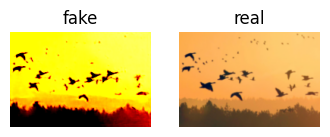

[init] copied weights from scale 1 → 0


it scale 0:   0%|          | 0/2000 [00:00<?, ?it/s]

[scale 0 | it 0]  Lips ≈ 0.63
[scale 0 | it 0]  LR = 5.00e-04


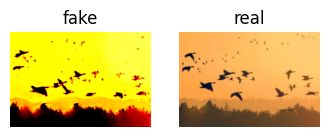

it scale 0:  10%|█         | 200/2000 [01:58<17:47,  1.69it/s]

[scale 0 | it 200]  Lips ≈ 1.51
[scale 0 | it 200]  LR = 5.00e-04


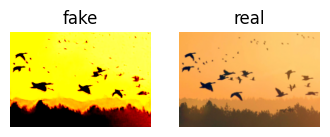

it scale 0:  20%|██        | 400/2000 [03:57<15:48,  1.69it/s]

[scale 0 | it 400]  Lips ≈ 0.88
[scale 0 | it 400]  LR = 5.00e-04


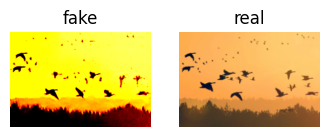

it scale 0:  30%|███       | 600/2000 [05:57<13:59,  1.67it/s]

[scale 0 | it 600]  Lips ≈ 1.09
[scale 0 | it 600]  LR = 5.00e-04


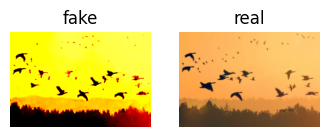

it scale 0:  40%|████      | 800/2000 [07:56<11:57,  1.67it/s]

[scale 0 | it 800]  Lips ≈ 1.29
[scale 0 | it 800]  LR = 5.00e-04


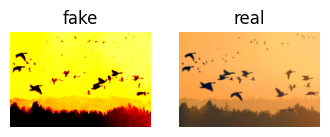

it scale 0:  50%|█████     | 1000/2000 [09:55<09:52,  1.69it/s]

[scale 0 | it 1000]  Lips ≈ 1.53
[scale 0 | it 1000]  LR = 5.00e-04


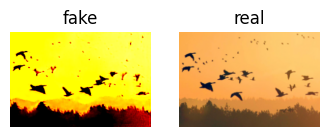

it scale 0:  60%|██████    | 1200/2000 [11:54<07:55,  1.68it/s]

[scale 0 | it 1200]  Lips ≈ 1.29
[scale 0 | it 1200]  LR = 5.00e-04


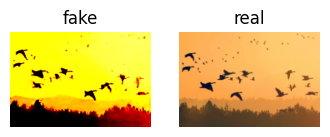

it scale 0:  70%|███████   | 1400/2000 [13:53<05:57,  1.68it/s]

[scale 0 | it 1400]  Lips ≈ 0.88
[scale 0 | it 1400]  LR = 5.00e-04


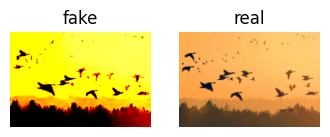

it scale 0:  80%|████████  | 1600/2000 [15:54<04:08,  1.61it/s]

[scale 0 | it 1600]  Lips ≈ 1.04
[scale 0 | it 1600]  LR = 5.00e-04


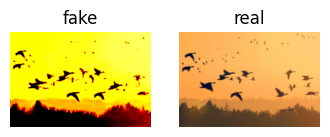

it scale 0:  90%|█████████ | 1800/2000 [17:55<01:59,  1.68it/s]

[scale 0 | it 1800]  Lips ≈ 1.49
[scale 0 | it 1800]  LR = 5.00e-04


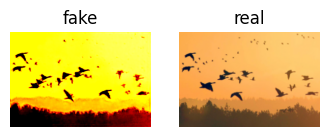

it scale 0: 100%|█████████▉| 1999/2000 [19:54<00:00,  1.68it/s]

[scale 0 | it 1999]  Lips ≈ 0.72
[scale 0 | it 1999]  LR = 5.00e-04


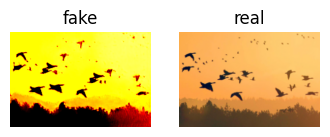

In [ ]:
torch.random.manual_seed(0)

# params
lambda_gp    = 10
lr             = 5e-4 # celui du github
betas            = (0.5, 0.999) # pareil
n_Discriminator  = 5 # pif
n_Generator      = 2 # pif
iter_per_scale   = 2000 # github
alpha_rec      = 10 # gith
beta_sigma   = 0.1 # git
debug          = True
b          = 1                                      # batch size
N = len(scales)
# reset des optim. #schedulers ???
optimizer_G, optimizer_D = [], []
for i in range(N):
    optimizer_G.append(optim.Adam(Genarators[i].parameters(), lr=lr, betas=betas))
    optimizer_D.append(optim.Adam(Discriminators[i].parameters(), lr=lr, betas=betas))

# --- LR schedulers -----------------------------------------------------------
# Each StepLR will keep the LR unchanged for 1 600 iterations, then multiply it
# by 0.1 once, and keep the new value for the remaining ~400 iterations.
scheduler_G, scheduler_D = [], []

step_size   = 2400          # when to trigger the decay
gamma       = 0.1            # multiplicative factor

for opt_G, opt_D in zip(optimizer_G, optimizer_D):
    scheduler_G.append(
        torch.optim.lr_scheduler.StepLR(opt_G, step_size=step_size, gamma=gamma)
    )
    scheduler_D.append(
        torch.optim.lr_scheduler.StepLR(opt_D, step_size=step_size, gamma=gamma)
    )


z_star   = torch.randn_like(scales[-1])               # bruit fixe
sigma_n  = [1.] * N
x_rec    = [None] * N
gen_image = [torch.zeros_like(scales[-1]).to(device)]
       

@torch.no_grad()
def regenerate_prev(k):
    # k : res actuelle
    # retourne une nouvelle image avec le générateur précedent.
    # reprend la dernière image généré et rajoute du bruit puis upsample`
    if k == N-1:
        return torch.zeros_like(scales[k]).to(device)

    low_prev = gen_image[-1]                           
    z_prev   = torch.randn_like(low_prev) * sigma_n[k+1]
    low_fake = Genarators[k+1](z_prev + low_prev) + low_prev

    prev_img = F.interpolate(low_fake,
                             size=scales[k].shape[2:], 
                             mode='bilinear', align_corners=False)
    return prev_img

@torch.no_grad()
def regenerate_prev_full(k):
    """
    Reconstruit un prev_img pour l'échelle k en:
      +  partant d'une image nulle au coarse (N-1),
      + appliquant *tous* les G gelés (N-1 … k+1) avec nouveau bruit,
      +  upsamplant le résultat (k+1) → résolution de k.
    """
    if k == N-1:                                    # échelle coarse → zeros
        return torch.zeros_like(scales[k]).to(device)

    # scale la plus petite
    img = torch.zeros_like(scales[-1]).to(device)   
    z   = torch.randn_like(img) * sigma_n[N-1]
    img = Genarators[N-1](z)                       

    # on remonte le réseau
    for s in range(N-2, k, -1):                     
        img_up = F.interpolate(img,
                               size=scales[s].shape[2:],
                               mode='bilinear', align_corners=False)
        z      = torch.randn_like(img_up) * sigma_n[s]
        img    = Genarators[s](z + img_up) + img_up

    prev_img = F.interpolate(img,
                             size=scales[k].shape[2:],
                             mode='bilinear', align_corners=False)
    return prev_img

def lipconstant(D, x, y):
    
    b = x.size(0)
    if y.size(0) != b:
        raise ValueError("batch sizes differ")

    alpha = torch.rand((b,1,1,1), device=device)
    interp = alpha * y + (1 - alpha) * x
    interp.requires_grad_(True)

    Di = D(interp).mean()                    # mean sinon ça me donnait des truc abbérant
    gradients = torch.autograd.grad(
        outputs=Di, inputs=interp,
        grad_outputs=torch.ones_like(Di),    
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]

    eps = 1e-12
    gradients_norm = torch.sqrt(gradients.flatten(1).pow(2).sum(1) + eps)
    return gradients_norm.mean()

# trainning toutes les scales
for n in range(N):
    current_res  = N - n - 1          
    Gk = Genarators[current_res].train()
    Dk = Discriminators[current_res].train()
    xk_real = scales[current_res].to(device)
    
    
    if current_res < N-1:                          
        G_prev = Genarators[current_res + 1]
        D_prev = Discriminators[current_res + 1]

        def same_channels(net_a, net_b):
            """return True if first conv out-channels match"""
            for m_a, m_b in zip(net_a.modules(), net_b.modules()):
                if isinstance(m_a, torch.nn.Conv2d):
                    return m_a.out_channels == m_b.out_channels
            return False

        if same_channels(Gk, G_prev):              
            Gk.load_state_dict(G_prev.state_dict(), strict=True)
            Dk.load_state_dict(D_prev.state_dict(), strict=True)
            if debug:
                print(f"[init] copied weights from scale {current_res+1} → {current_res}")

    # NB: from here on, use *Gk* / *Dk*; they already sit in the
    #     Genarators / Discriminators lists, so nothing else changes.
    Gk.train();  Dk.train()
    # (re-attach the optimisers in case parameters were just overwritten)
    opt_G = optimizer_G[current_res]
    opt_D = optimizer_D[current_res]
    

# Calcul ecart type nécessaire pour le bruit.
    if current_res < N-1:
        up_rec = F.interpolate(x_rec[current_res+1],
                               size=xk_real.shape[2:], mode='bilinear', align_corners=False)

        # σ_n = β · RMSE((x_rec[n+1]↑), x_n) / RMSE(0, x_n) # formule trouvé je sais plus ou. 
        num   = F.mse_loss(up_rec, xk_real)             
        denom = F.mse_loss(torch.zeros_like(xk_real), xk_real)
        sigma_n[current_res] = beta_sigma * torch.sqrt(num / denom)   
    else:
        sigma_n[current_res] = torch.tensor(1, device=device)

    # itérations par scale
    for it in tqdm(range(iter_per_scale), desc=f"it scale {current_res}", leave=False):

        # prev_img tiré fraichement
        with torch.no_grad():
            prev_img = regenerate_prev_full(current_res)

        # trainning discriminateur
        for _ in range(n_Discriminator):
            opt_D.zero_grad()
            z = torch.randn_like(prev_img) * sigma_n[current_res]
            fake = Gk(z + prev_img) + prev_img

            loss_D = Dk(fake.detach()).mean() - Dk(xk_real).mean()

            # gradient penalty
            alpha = torch.rand(b,1,1,1,device=device)
            interp = (alpha*xk_real + (1-alpha)*fake.detach()).requires_grad_(True)
            grad_out = Dk(interp).mean()
            grad = torch.autograd.grad(grad_out, interp, torch.ones_like(grad_out),
                                       create_graph=True, retain_graph=True, only_inputs=True)[0]
            gp = lambda_gp * ((grad.flatten(1).norm(2,dim=1)-1)**2).mean()
            (loss_D + gp).backward()
            opt_D.step()

       

        for g_idx in range(n_Generator):
            opt_G.zero_grad()
            z = torch.randn_like(prev_img) * sigma_n[current_res]
            fake = Gk(z + prev_img) + prev_img
            adv_G = -Dk(fake).mean()

            # ----- Reconstruction eq. 5 -----
            if current_res == N-1:                         # coarse
                rec_in = z_star                             # MOD (z_star)
                rec_out = Gk(rec_in)                       # pas de upsample
            else:                                          # n < N
                up_fixed = F.interpolate(x_rec[current_res+1],
                                          size=xk_real.shape[2:], mode='bilinear', align_corners=False)
                rec_in = up_fixed                          # MOD (bruit = 0)
                rec_out = Gk(rec_in) + up_fixed            # MOD

            Lrec = F.mse_loss(rec_out, xk_real)
            (adv_G + alpha_rec * Lrec).backward()
            opt_G.step()
        
        # ---- advance LR scheduler *once* for this outer iteration
        scheduler_D[current_res].step()
        scheduler_G[current_res].step()
        
        # logs
        if debug and (it % 200 == 0 or it==iter_per_scale-1):
            # pas de torch.no_grad() ici : on a besoin du backward dans lipconstant
            lips = lipconstant(Dk, fake.detach(), xk_real)
            print(f"[scale {current_res} | it {it}]  Lips ≈ {lips:.2f}")
            current_lr = opt_G.param_groups[0]['lr']
            print(f"[scale {current_res} | it {it}]  LR = {current_lr:.2e}")

            with torch.no_grad():                     # on garde no_grad pour l’affichage
                plt.figure(figsize=(4,2))
                plt.subplot(1,2,1); plt.imshow(pil_from_minus1to1(fake[0].cpu())); plt.axis('off'); plt.title('fake')
                plt.subplot(1,2,2); plt.imshow(pil_from_minus1to1(xk_real[0].cpu()));        plt.axis('off'); plt.title('real')
                plt.show()
    # fige G_k et stocke fake pour l’échelle au-dessus 
    with torch.no_grad():
        gen_image.append(fake.detach())
        if current_res == N-1:
            x_rec[current_res] = Gk(z_star)                              # NEW (bruit fixe)
        else:
            up_rec_k = F.interpolate(x_rec[current_res+1], size=xk_real.shape[2:], mode='bilinear', align_corners=False)
            x_rec[current_res] = Gk(up_rec_k) + up_rec_k                 # NEW (bruit 0)
        Gk.eval()
        for p in Gk.parameters(): 
            p.requires_grad_(False)


SAVING GENERATORS AND OR LOADING OTHERS

In [43]:
# ==== SAVE GENERATORS ========================================================
import os, datetime, torch, json

model_name = "no_recloss"                        # ⬅️  choisis ton nom
model_dir  = os.path.join("models", model_name)
weights_fp = os.path.join(model_dir, "generators.pt")
descr_fp   = os.path.join(model_dir, "Description.txt")

if os.path.exists(model_dir):
    print(f"ATTENTION : Un modèle nommé '{model_name}' existe déjà dans '{model_dir}'.")
    print("   → Choisis un autre nom pour ne pas l'écraser.")
else:
    os.makedirs(model_dir, exist_ok=True)

    # 1) sauvegarde des poids : liste d'état (un par G_k)
    torch.save([G.state_dict() for G in Genarators], weights_fp)

    # 2) petit fichier description (texte lisible)
    description = {
        "date"           : datetime.datetime.now().isoformat(timespec="seconds"),
        "N"              : N,
        "lambda_gp"      : lambda_gp,
        "lr"             : lr,
        "betas"          : betas,
        "n_Discriminator": n_Discriminator,
        "n_Generator"    : n_Generator,
        "iter_per_scale" : iter_per_scale,
        "alpha_rec"      : alpha_rec,
        "beta_sigma"     : beta_sigma,
        "comment"        : "Sin Gan classique sans rec loss et sans padding",
    }
    with open(descr_fp, "w", encoding="utf-8") as f:
        for k, v in description.items():
            f.write(f"{k}: {v}\n")

    print(f"Générateurs sauvegardés dans  {weights_fp}")
    print(f"Description créée          -> {descr_fp}")


Générateurs sauvegardés dans  models/no_recloss/generators.pt
Description créée          -> models/no_recloss/Description.txt


In [27]:
# ===================== LOAD A CHECKPOINT, WHATEVER IS IN MEMORY =====================
import os, torch

# --- (1) nom du modèle à charger -----------------------------------------------------
model_name = "basic"                  # ← remplace par le tien
model_dir  = os.path.join("models", model_name)
weights_fp = os.path.join(model_dir, "generators.pt")
descr_fp   = os.path.join(model_dir, "Description.txt")

if not os.path.exists(weights_fp):
    raise FileNotFoundError(f"Impossible de trouver le fichier : {weights_fp}")

# --- (2) on lit la liste de state_dict ----------------------------------------------
state_list = torch.load(weights_fp, map_location="cpu")   # toujours sur CPU d'abord

print(f"{len(state_list)} générateurs trouvés dans le checkpoint")

# (facultatif) on affiche le petit fichier description
if os.path.isfile(descr_fp):
    print("─── Description.txt ───")
    with open(descr_fp, encoding="utf-8") as f:
        print(f.read().strip())
    print("────────────────────────\n")

# --- (3) fonction helper : recrée un Generator adapté au state_dict -----------------
def build_generator_from_state(sd, device="cpu"):
    """
    Reconstruit un objet Generator avec la bonne dimension cachée
    en regardant le 1er conv du state_dict.
    """
    # on détecte le nombre de canaux de sortie du premier conv
    # (selon ton code : 'head.conv.weight' ou 'main.0.weight')
    for key in sd.keys():
        if key.endswith(".weight") and sd[key].dim() == 4:   # conv 2d
            n_hidden = sd[key].shape[0]   
            print("n_hidden found", n_hidden)# out_channels
            break
    else:
        raise KeyError("Impossible d'inférer n_hidden depuis le state_dict.")

    G = Generator(n_hidden).to(device)
    G.load_state_dict(sd, strict=True)
    G.eval()
    for p in G.parameters():
        p.requires_grad_(False)
    return G

# --- (4) on construit la liste des générateurs chargés --------------------------------
device = torch.device("mps" if torch.mps.is_available() else "cpu")
loaded_generators = [build_generator_from_state(sd, device=device) for sd in state_list]

print(f"{len(loaded_generators)} générateurs instanciés → liste 'loaded_generators'")


7 générateurs trouvés dans le checkpoint
─── Description.txt ───
date: 2025-05-26T15:13:59
N: 7
lambda_gp: 10
lr: 0.0005
betas: (0.5, 0.999)
n_Discriminator: 5
n_Generator: 2
iter_per_scale: 2000
alpha_rec: 10
beta_sigma: 0.1
comment: Sin Gan avec poids classique comme dans le papier sauf le padding
────────────────────────

n_hidden found 32
n_hidden found 32
n_hidden found 32
n_hidden found 64
n_hidden found 64
n_hidden found 64
n_hidden found 64
7 générateurs instanciés → liste 'loaded_generators'


In [28]:
@torch.no_grad()
def generate_multiscale(start_scale: int = N - 1,Generators = Genarators):
    """
    start_scale = 0  → on ne renouvelle le bruit qu’à la fine scale
    start_scale = N-1→ on renouvelle le bruit à toutes les échelles
    """
    # Génération totale
    if start_scale == N-1 : 
        h, w = scales[-1].shape[2:]
        gen_image = [torch.zeros((1, 3, h, w), device=device)]

         # 2. on remonte coarse → fine
        for i in range(N):
            k = N - 1 - i                    
        
            prev = gen_image[-1]
            if prev.shape[2:] != scales[k].shape[2:]:
                prev = F.interpolate(prev, size=scales[k].shape[2:],
                                    mode='bilinear', align_corners=False)

            z = torch.randn_like(prev) * sigma_n[k]
            

            x_k = Generators[k](z + prev) + prev
            gen_image.append(x_k)

        

    else : 
        low = scales[start_scale+1] 
        up = F.interpolate(low, size=scales[start_scale].shape[2:],
                                    mode='bilinear', align_corners=False)
        gen_image = [up]

         # 2. on remonte coarse → fine
        for scale in range(start_scale,-1,-1):
                            
            prev = gen_image[-1]
            if prev.shape[2:] != scales[scale].shape[2:]:
                prev = F.interpolate(prev, size=scales[scale].shape[2:],
                                    mode='bilinear', align_corners=False)

            z = torch.randn_like(prev) * sigma_n[scale]
            x_k = Genarators[scale](z + prev) + prev
            gen_image.append(x_k)

    
    return gen_image[1:]
        
    


In [29]:
# 1. Collecter toutes les images pour connaître la taille de la grille
rows      = []                 # liste des listes d’images (Tensor)
max_cols  = 0
for s in range(N):
    imgs = generate_multiscale(start_scale=s,Generators=loaded_generators)   # list[Tensor]
    rows.append(imgs)
    max_cols = max(max_cols, len(imgs))

# 2. Créer la figure
cell = 3.0                     # taille (pouces) d’une cellule
fig_w, fig_h = cell * max_cols, cell * N
fig, axes = plt.subplots(N, max_cols, figsize=(fig_w, fig_h), squeeze=False)

# 3. Remplir le tableau
for r, (s, imgs) in enumerate(zip(range(N), rows)):
    for c in range(max_cols):
        ax = axes[r, c]

        if c < len(imgs):
            img_pil = pil_from_minus1to1(imgs[c].cpu().squeeze())
            
            ax.imshow(img_pil)
            ax.set_title(f"s={s}  i={c}", fontsize=8)
        else:
            ax.axis('off')          # cellule vide

        ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
plt.show()

NameError: name 'sigma_n' is not defined

saved → models/no_recloss/outputs/gen_20250526_212424_1.png
saved → models/no_recloss/outputs/gen_20250526_212424_2.png
saved → models/no_recloss/outputs/gen_20250526_212424_3.png
saved → models/no_recloss/outputs/gen_20250526_212424_4.png
saved → models/no_recloss/outputs/gen_20250526_212424_5.png
saved → models/no_recloss/outputs/gen_20250526_212425_6.png
saved → models/no_recloss/outputs/gen_20250526_212425_7.png
saved → models/no_recloss/outputs/gen_20250526_212425_8.png


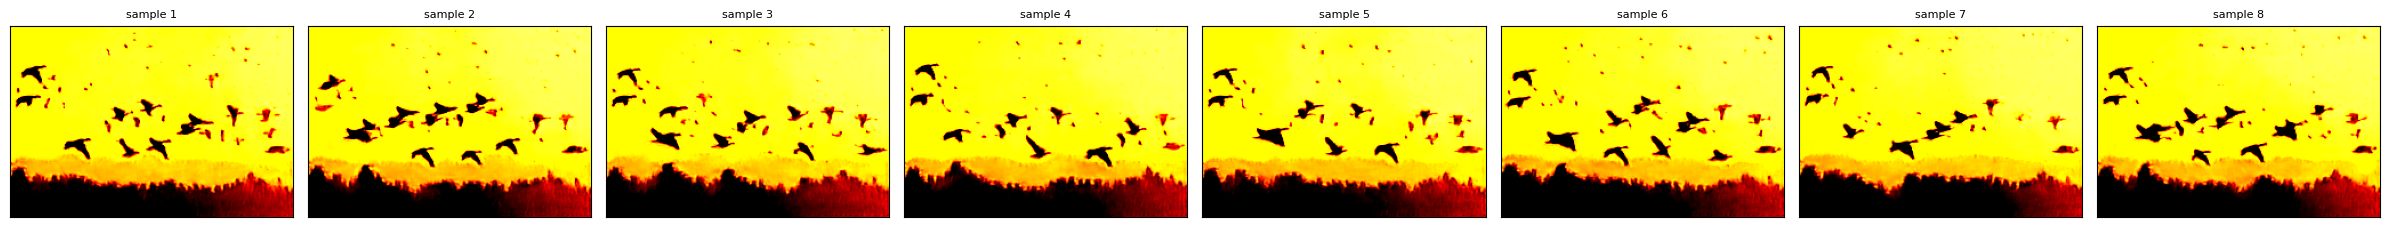

In [47]:
import torchvision.utils as vutils
import os, time

# dossier de sortie
out_dir = "models/no_recloss/outputs"
os.makedirs(out_dir, exist_ok=True)

# Nombre de générations
K = 8
final_imgs = []
for k in range(K):
    imgs = generate_multiscale(start_scale=N-1,Generators=loaded_generators)
    final_imgs.append(imgs[-1].cpu().squeeze())      # dernière image

# affichage + sauvegarde
cell = 3.0
fig, axes = plt.subplots(1, K, figsize=(cell*K, cell), squeeze=False)

for idx, (ax, img) in enumerate(zip(axes[0], final_imgs), 1):
    # plot
    ax.imshow(pil_from_minus1to1(img))
    ax.set_title(f"sample {idx}", fontsize=8)
    ax.set_xticks([]); ax.set_yticks([])

    # sauvegarde
    img_01 = ((img.clamp(-1, 1) + 1) / 2)            # [-1,1] → [0,1]
    filename = os.path.join(
        out_dir, f"gen_{time.strftime('%Y%m%d_%H%M%S')}_{idx}.png"
    )
    vutils.save_image(img_01, filename)
    print(f"saved → {filename}")

plt.tight_layout()
plt.show()


Reconstruction de XREC

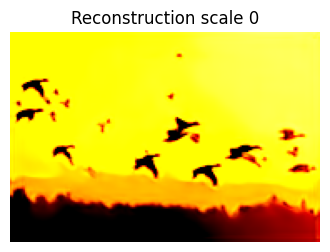

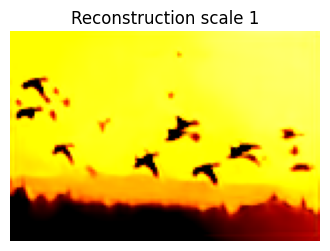

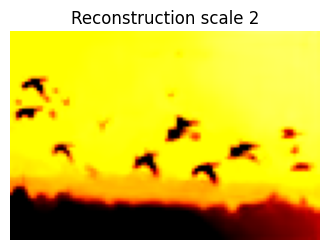

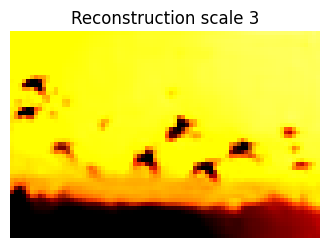

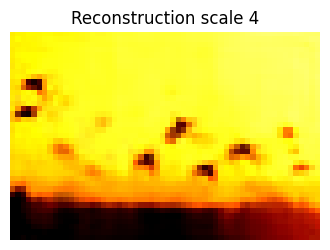

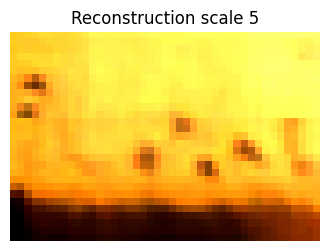

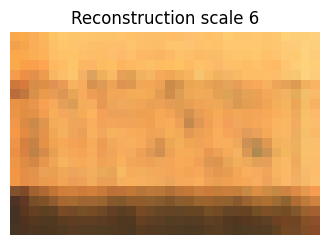

In [48]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def plot_reconstructions(x_rec, scales):
    for i, rec in enumerate(x_rec):
        if rec is None:
            continue
        img = rec.detach().cpu().squeeze()
        plt.figure(figsize=(4,4))
        plt.title(f"Reconstruction scale {i}")
        plt.imshow(pil_from_minus1to1(img))
        plt.axis('off')
        plt.show()

plot_reconstructions(x_rec[1:],scales)